In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

In [3]:
#Load dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("workout_fitness_tracker_data.csv")
df.head()

Saving workout_fitness_tracker_data.csv to workout_fitness_tracker_data (1).csv


,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Workout Intensity,Sleep Hours,Water Intake (liters),Daily Calories Intake,Resting Heart Rate (bpm),VO2 Max,Body Fat (%),Mood Before Workout,Mood After Workout
0,1,39,Male,175,99,Cycling,79,384,112,8850,14.44,High,8.2,1.9,3195,61,38.4,28.5,Tired,Fatigued
1,2,36,Other,157,112,Cardio,73,612,168,2821,1.10,High,8.6,1.9,2541,73,38.4,28.5,Happy,Energized
2,3,25,Female,180,66,HIIT,27,540,133,18898,7.28,High,9.8,1.9,3362,80,38.4,28.5,Happy,Fatigued
3,4,56,Male,154,89,Cycling,39,672,118,14102,6.55,Medium,5.8,1.9,2071,65,38.4,28.5,Neutral,Neutral
4,5,53,Other,194,59,Strength,56,410,170,16518,3.17,Medium,7.3,1.9,3298,59,38.4,28.5,Stressed,Energized


In [4]:
print(df.columns.tolist())

['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)', 'Workout Type', 'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity', 'Sleep Hours', 'Water Intake (liters)', 'Daily Calories Intake', 'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)', 'Mood Before Workout', 'Mood After Workout']


In [5]:
#Define the dropout generation function
def generate_dropout_label(row):
    before = row['Mood Before Workout']
    after = row['Mood After Workout']
    intensity = row['Workout Intensity']
    duration = row['Workout Duration (mins)']

    #we can keep a threshold
    if (
        before in ['Tired', 'Stressed'] and
        after in ['Fatigued', 'Neutral'] and
        intensity in ['Low'] and
        duration < 30  #threshold
    ):
        return 1  # Dropped out
    return 0  # Active

#Apply the function to create the Dropout column
df['Dropout'] = df.apply(generate_dropout_label, axis=1)

print(df[['Mood Before Workout', 'Mood After Workout', 'Workout Intensity',
          'Workout Duration (mins)', 'Dropout']].head())

#Save the updated dataset
df.to_csv("workout_fitness_tracker_data_with_dropout.csv", index=False)
df.head()

  Mood Before Workout Mood After Workout Workout Intensity  \
0               Tired           Fatigued              High   
1               Happy          Energized              High   
2               Happy           Fatigued              High   
3             Neutral            Neutral            Medium   
4            Stressed          Energized            Medium   

   Workout Duration (mins)  Dropout  
0                       79        0  
1                       73        0  
2                       27        0  
3                       39        0  
4                       56        0  


,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,...,Workout Intensity,Sleep Hours,Water Intake (liters),Daily Calories Intake,Resting Heart Rate (bpm),VO2 Max,Body Fat (%),Mood Before Workout,Mood After Workout,Dropout
0,1,39,Male,175,99,Cycling,79,384,112,8850,...,High,8.2,1.9,3195,61,38.4,28.5,Tired,Fatigued,0
1,2,36,Other,157,112,Cardio,73,612,168,2821,...,High,8.6,1.9,2541,73,38.4,28.5,Happy,Energized,0
2,3,25,Female,180,66,HIIT,27,540,133,18898,...,High,9.8,1.9,3362,80,38.4,28.5,Happy,Fatigued,0
3,4,56,Male,154,89,Cycling,39,672,118,14102,...,Medium,5.8,1.9,2071,65,38.4,28.5,Neutral,Neutral,0
4,5,53,Other,194,59,Strength,56,410,170,16518,...,Medium,7.3,1.9,3298,59,38.4,28.5,Stressed,Energized,0


In [6]:
#to see how big the data is we print no. of rows and columns
print(df.shape)

#see column names, data types
print(df.info())

#Check if any values are missing in any column
print(df.isnull().sum())

#See if there are any duplicate rows
print("duplicated rows:",df.duplicated().sum())

#Show summary stats for number columns To check for weird values
print(df.describe())

print(df.columns.tolist())

(10000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User ID                   10000 non-null  int64  
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Height (cm)               10000 non-null  int64  
 4   Weight (kg)               10000 non-null  int64  
 5   Workout Type              10000 non-null  object 
 6   Workout Duration (mins)   10000 non-null  int64  
 7   Calories Burned           10000 non-null  int64  
 8   Heart Rate (bpm)          10000 non-null  int64  
 9   Steps Taken               10000 non-null  int64  
 10  Distance (km)             10000 non-null  float64
 11  Workout Intensity         10000 non-null  object 
 12  Sleep Hours               10000 non-null  float64
 13  Water Intake (liters)     10000 non-null  float64


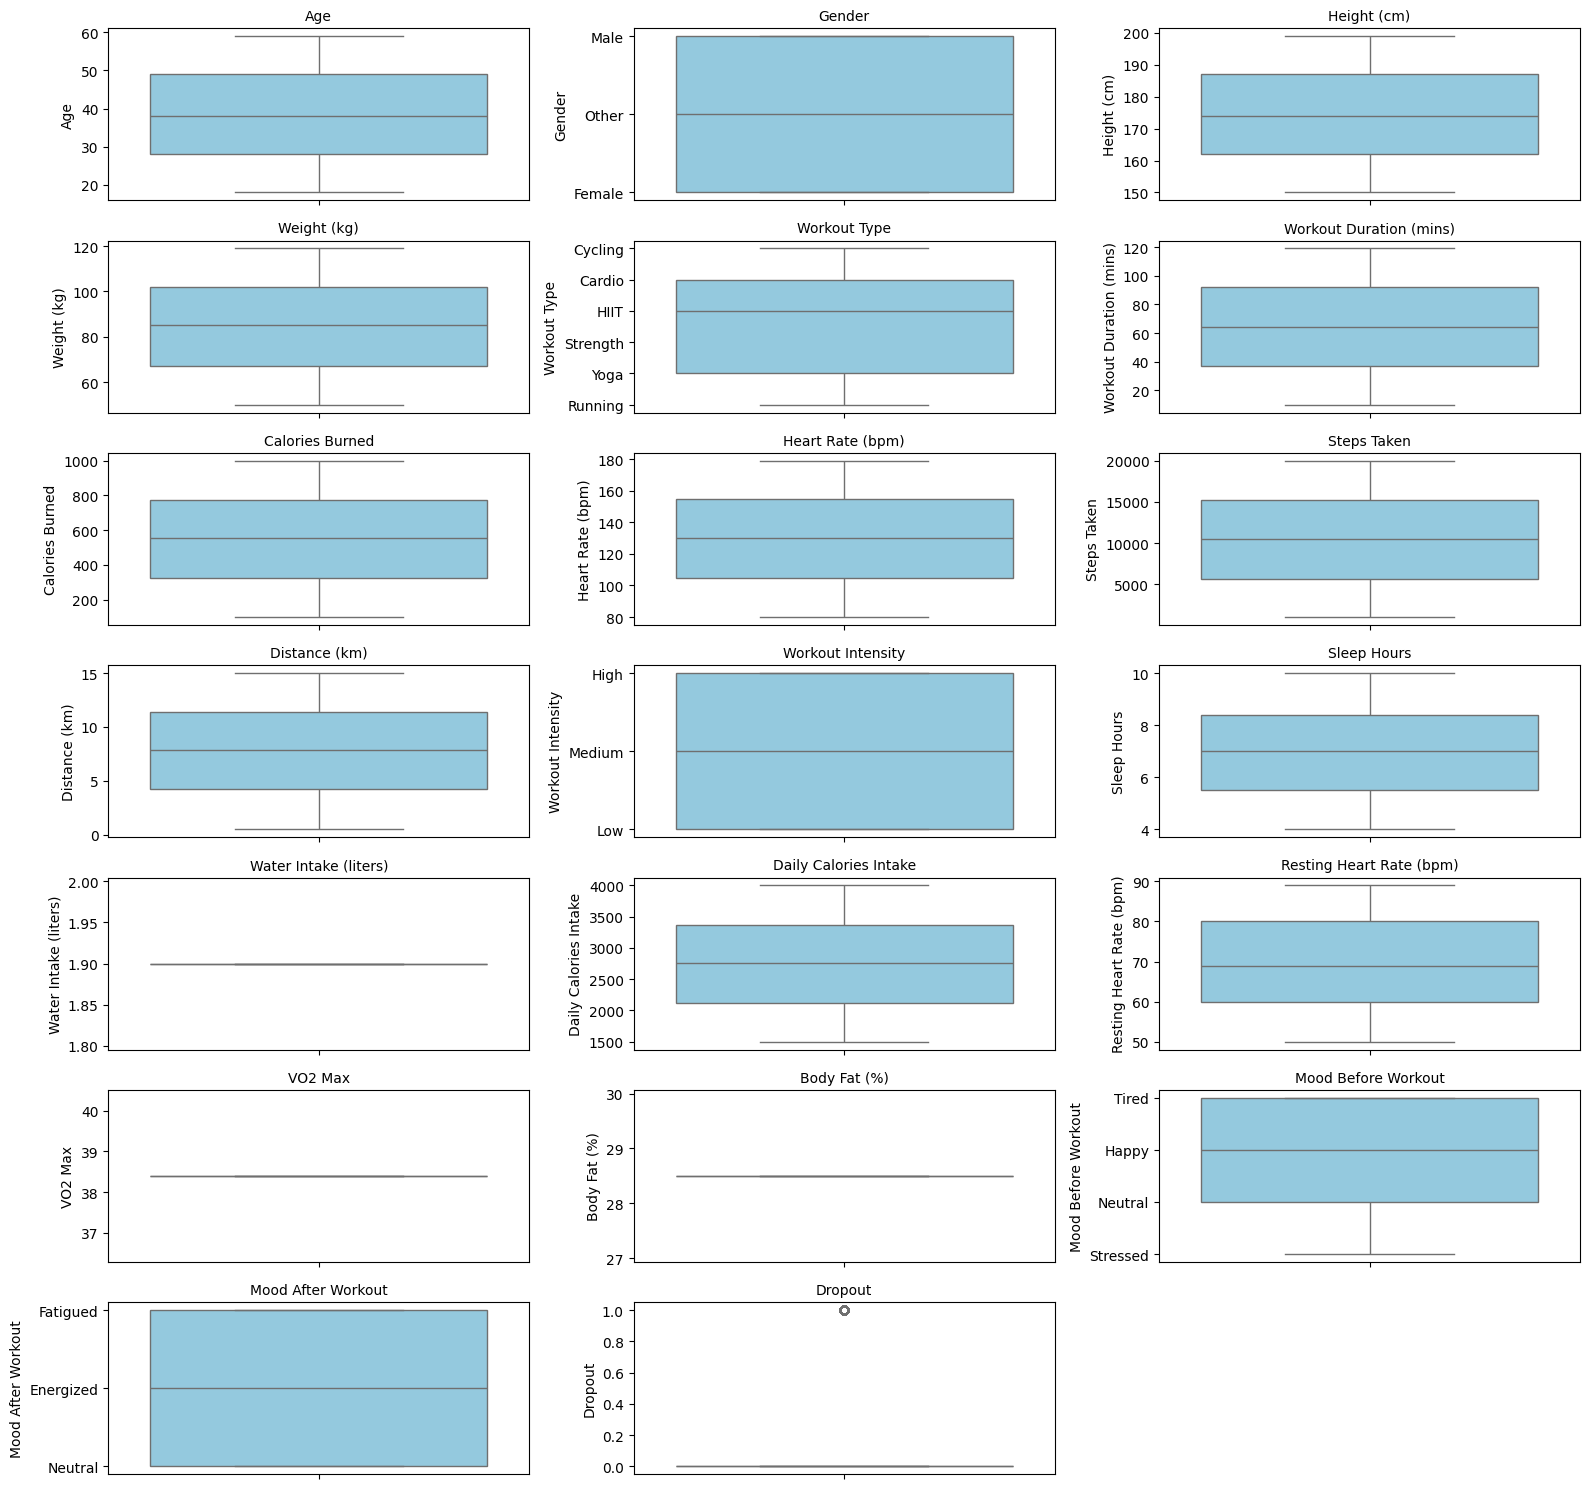

In [7]:
# Drop 'User ID' because it's just an identifier
numeric_cols = [col for col in df.columns if col not in ['User ID']]

# Create boxplots for each numeric column
plt.figure(figsize=(16,15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) // 3) + 1, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

In [8]:
categorical_cols = ['Gender', 'Workout Type', 'Workout Intensity', 'Mood Before Workout', 'Mood After Workout']

# Initialize encoder for new scikit-learn
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Fit-transform categorical columns
encoded_array = ohe.fit_transform(df[categorical_cols])

# Convert back to DataFrame with column names
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded ones
df_encoded = pd.concat([df.drop(columns=categorical_cols).reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)

print("Encoded dataframe shape:", df_encoded.shape)
df_encoded.head()

Encoded dataframe shape: (10000, 35)


,User ID,Age,Height (cm),Weight (kg),Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Sleep Hours,...,Workout Intensity_High,Workout Intensity_Low,Workout Intensity_Medium,Mood Before Workout_Happy,Mood Before Workout_Neutral,Mood Before Workout_Stressed,Mood Before Workout_Tired,Mood After Workout_Energized,Mood After Workout_Fatigued,Mood After Workout_Neutral
0,1,39,175,99,79,384,112,8850,14.44,8.2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2,36,157,112,73,612,168,2821,1.10,8.6,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,25,180,66,27,540,133,18898,7.28,9.8,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,56,154,89,39,672,118,14102,6.55,5.8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,53,194,59,56,410,170,16518,3.17,7.3,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
# Scale numerical columns on the encoded dataset
num_cols = ['User ID', 'Age', 'Height (cm)', 'Weight (kg)','Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)','Steps Taken', 'Distance (km)', 'Sleep Hours',
            'Water Intake (liters)', 'Daily Calories Intake', 'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)']

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Separate features and target from the encoded dataset
X = df_encoded.drop('Dropout', axis=1)
y = df_encoded['Dropout']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
# Prepare tensors
X_tensor = torch.tensor(df_encoded.drop(columns=['Dropout']).values, dtype=torch.float32)
y_tensor = torch.tensor(df_encoded['Dropout'].values, dtype=torch.float32).view(-1, 1)

In [13]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

input_size = X_tensor.shape[1]
model = MLP(input_size)

#Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training Loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

#Predictions
with torch.no_grad():
    y_pred_probs = model(X_tensor).numpy()
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)

Epoch [10/50], Loss: 0.4948
Epoch [20/50], Loss: 0.3447
Epoch [30/50], Loss: 0.2001
Epoch [40/50], Loss: 0.1213
Epoch [50/50], Loss: 0.0983


In [14]:
# Classification report
print(classification_report(y_tensor.numpy(), y_pred_labels, digits=4))

              precision    recall  f1-score   support

         0.0     0.9794    1.0000    0.9896      9794
         1.0     0.0000    0.0000    0.0000       206

    accuracy                         0.9794     10000
   macro avg     0.4897    0.5000    0.4948     10000
weighted avg     0.9592    0.9794    0.9692     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
